# 03 – MRR Forecasting

This notebook aggregates subscription revenue into monthly MRR and fits a simple trend-based forecast.
The goal is to illustrate how revenue is evolving over time and project future MRR under current conditions.


In [1]:
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


PROC_DIR = "data/processed"
monthly_path = os.path.join(PROC_DIR, "monthly_activity.csv")

monthly_df = pd.read_csv(monthly_path, parse_dates=["month"])
monthly_df.head()


,subscription_id,customer_id,plan_id,month,cohort_month,is_active,is_new,churned_this_month,mrr_usd
0,1,5,4,2023-01-01,2023-01-01,True,True,False,24.92
1,1,5,4,2023-02-01,2023-01-01,True,False,False,24.92
2,1,5,4,2023-03-01,2023-01-01,True,False,False,24.92
3,1,5,4,2023-04-01,2023-01-01,True,False,False,24.92
4,1,5,4,2023-05-01,2023-01-01,True,False,False,24.92


## Monthly MRR aggregation


In [2]:
mrr_over_time = (
    monthly_df.groupby("month")["mrr_usd"]
    .sum()
    .reset_index()
    .sort_values("month")
)

mrr_over_time.head()

,month,mrr_usd
0,2022-01-01,825.28
1,2022-02-01,3302.68
2,2022-03-01,6467.76
3,2022-04-01,10917.28
4,2022-05-01,13995.52


## MRR trend over time


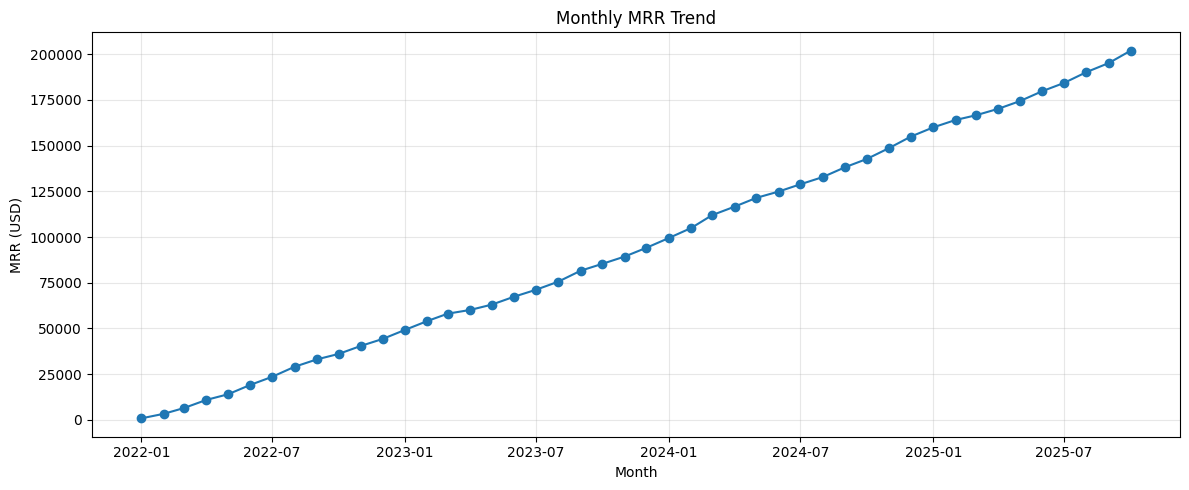

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(mrr_over_time["month"], mrr_over_time["mrr_usd"], marker="o")
plt.title("Monthly MRR Trend")
plt.xlabel("Month")
plt.ylabel("MRR (USD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Fit simple MRR forecast
Using Holt-Winters Exponential Smoothing (trend only).


In [4]:
# Prepare series
mrr_series = mrr_over_time.set_index("month")["mrr_usd"]

# Fit model (trend only, no seasonality unless synthetic data shows cycles)
model = ExponentialSmoothing(
    mrr_series,
    trend="add",
    seasonal=None
).fit()

# Forecast next 12 months
forecast_steps = 12
future_index = pd.date_range(
    start=mrr_series.index[-1] + pd.offsets.MonthBegin(1),
    periods=forecast_steps,
    freq="MS"
)
forecast = model.forecast(forecast_steps)
forecast = pd.Series(forecast, index=future_index)

forecast.head()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,0
2025-11-01,206399.071538
2025-12-01,210909.383109
2026-01-01,215419.694680
2026-02-01,219930.006252
2026-03-01,224440.317823


## Forecast visualisation


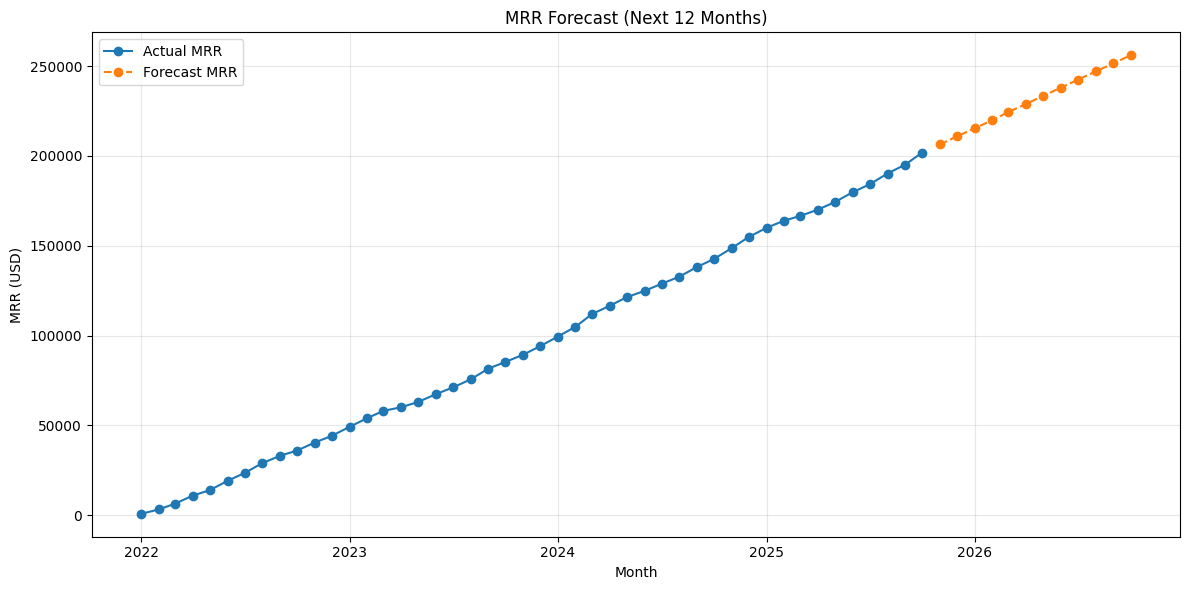

In [5]:
plt.figure(figsize=(12, 6))

# Actual
plt.plot(mrr_series.index, mrr_series.values, label="Actual MRR", marker="o")

# Forecast
plt.plot(forecast.index, forecast.values, label="Forecast MRR", marker="o", linestyle="--")

plt.title("MRR Forecast (Next 12 Months)")
plt.xlabel("Month")
plt.ylabel("MRR (USD)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Month-over-month growth rate


In [6]:
# Calculate month-over-month growth rate as a percentage to align with later notebooks
mrr_over_time["mom_growth_pct"] = (mrr_over_time["mrr_usd"].pct_change() * 100).round(2)

mrr_over_time.tail()

,month,mrr_usd,mom_growth_pct
41,2025-06-01,179789.08,3.12
42,2025-07-01,184270.08,2.49
43,2025-08-01,190189.40,3.21
44,2025-09-01,195167.36,2.62
45,2025-10-01,201888.76,3.44


## Forecast growth rate

In [7]:
forecast_growth = forecast.pct_change()
forecast_growth


,0
2025-11-01,NaN
2025-12-01,0.021852
2026-01-01,0.021385
2026-02-01,0.020937
2026-03-01,0.020508
2026-04-01,0.020096
2026-05-01,0.019700
2026-06-01,0.019319
2026-07-01,0.018953
2026-08-01,0.018601
